# Casos de dengue no Brasil

Nesta BD Letter vamos mostrar como está a situação dos municípios da nossa equipe BD Edu. Deixamos o código pronto, além de recomendações necessárias, para que você faça o mesmo para sua cidade também.

Nesta edição vamos trazer alguns destaques:
- 2024 teve um número de casos fora do normal para o Brasil
- a distribuição dos casos não é uniforme para todas as cidades

In [ ]:
!pip install basedosdados==2.0.0b16 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 1.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.38.0 requires pandas-gbq>=0.26.0, but you have pandas-gbq 0.19.2 which is incompatible.


In [ ]:
!pip install epiweeks

In [ ]:
import basedosdados as bd
from epiweeks import Week, Year
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

## Brasil

Nesta seção podemos ver como o número de casos em 2024 foi completamente fora da curva.

In [ ]:
select = f"""select ano, count(*) as casos
from `basedosdados.br_ms_sinan.microdados_dengue` dengue
WHERE classificacao_final IN ("10", "11", "12")
AND tipo_notificacao = "2"
group by ano
order by ano
  """

In [ ]:
df = bd.read_sql(select, billing_project_id='testes-proforest')

Downloading: 100%|██████████|


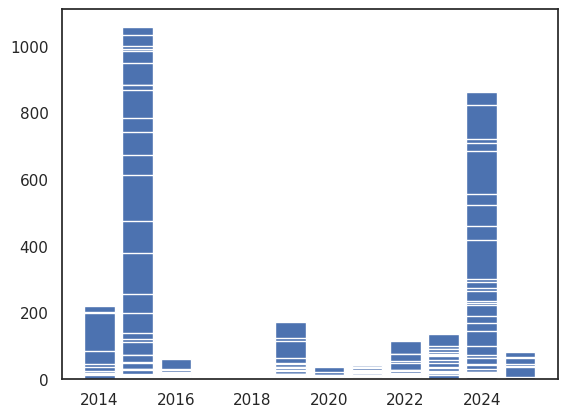

In [ ]:
sns.set_theme(style="white")
fig, ax = plt.subplots()
ax.bar(df.drop(11).ano, df.drop(11).casos)
fig.show()

Vamos ver a quantidade de casos nos dois primeiros meses de cada ano, para comparar todos os anos (embora essa comparação não seja a melhor forma de analisar)

In [ ]:
select = f"""select ano, count(*) as casos
from `basedosdados.br_ms_sinan.microdados_dengue` dengue
WHERE classificacao_final IN ("10", "11", "12")
AND tipo_notificacao = "2"
and extract(month from data_notificacao) in (1,2)
group by ano
order by ano
  """

In [ ]:
df = bd.read_sql(select, billing_project_id='testes-proforest')

Downloading: 100%|██████████|


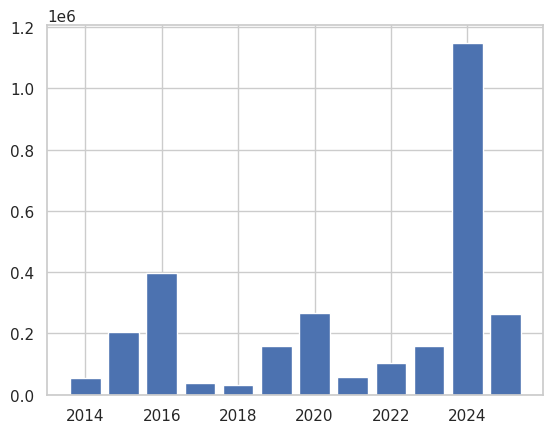

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax.bar(df.ano, df.casos)
fig.show()

Mas essa não é a melhor forma de ver, isso porque a distribuição de casos notificados ao longo das semanas epidemiologicas não é muito uniforme ao longo dos anos (as vezes começa a crescer mais cedo, as vezes mais tarde, etc)

In [ ]:
#pro brasil todo
select = """select data_notificacao as data, count(*) as casos
from `basedosdados.br_ms_sinan.microdados_dengue`
WHERE classificacao_final IN ("10", "11", "12")
AND tipo_notificacao = "2"
group by ano, data_notificacao
order by ano, data_notificacao
  """

In [ ]:
df = bd.read_sql(select, billing_project_id='testes-proforest')

Downloading: 100%|██████████|


In [ ]:
df['data'] = pd.to_datetime(df.data)

In [ ]:
df['semana'] = 0
df['ano'] = 1990

In [ ]:
#essa não é a forma mais eficiente de iterar, mas é a que eu vou usar
for i, row in df.iterrows():
  df.at[i,'semana'] = Week.fromdate(row['data'],'ISO').week
  df.at[i,'ano']=Week.fromdate(row['data'],'ISO').year

In [ ]:
casos = df.groupby(by=['ano','semana'])['casos'].sum().reset_index()


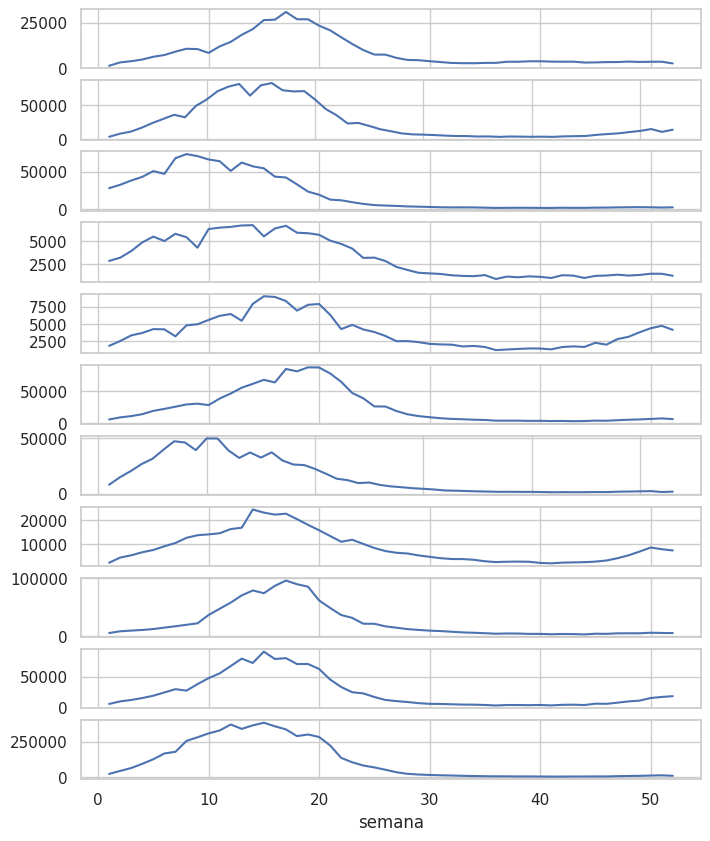

In [ ]:
fig, axs = plt.subplots(nrows=11, ncols=1, figsize=(8, 10))
axs = axs.flatten() # needed to access each individual axis

# iterate over axes
anos = np.arange(2014,2025)
for i, ano in enumerate(anos):

    # subset the data for each word
    subset = casos[casos['ano'] == ano]

    # plot the distribution of prices
    sns.lineplot(
        data=subset,
        x='semana',
        y='casos',
        ax=axs[i]
    )

    # set title and labels
    #axs[i].set_xlim(0, 10000)
    #axs[i].set_ylim(0, 0.001)
    axs[i].set_ylabel('')

plt.show()

## Cidade



In [ ]:
cidade = 'Sorocaba'

In [ ]:
select = f"""select data_notificacao as data, count(*) as casos
from `basedosdados.br_ms_sinan.microdados_dengue` dengue
join `basedosdados.br_bd_diretorios_brasil.municipio` municipio
on dengue.id_municipio_notificacao = municipio.id_municipio
WHERE classificacao_final IN ("10", "11", "12")
AND tipo_notificacao = "2"
AND municipio.nome = '{cidade}'
group by id_municipio_notificacao, ano, data_notificacao
order by id_municipio_notificacao, ano, data_notificacao
  """

In [ ]:
df = bd.read_sql(select, billing_project_id='testes-proforest')

Downloading: 100%|██████████|


In [ ]:
df['semana'] = 0
df['ano'] = 1990

In [ ]:
for i, row in df.iterrows():
  df.at[i,'semana'] = Week.fromdate(row['data'],'ISO').week
  df.at[i,'ano']=Week.fromdate(row['data'],'ISO').year

In [ ]:
casos = df.groupby(by=['ano','semana'])['casos'].sum().reset_index()

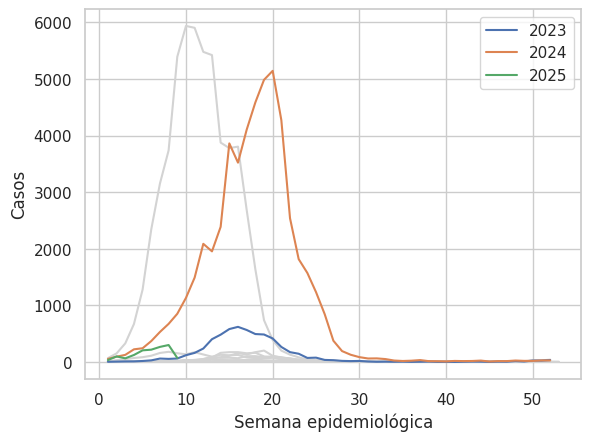

In [ ]:
fig, ax = plt.subplots()
for ano in np.arange(2014,2023):
  subset = casos[casos['ano'] == ano]
  ax.plot(subset['semana'],subset['casos'], color='lightgrey')
  ax.legend()

for ano in np.arange(2023,2026):
  subset = casos[casos['ano'] == ano]
  ax.plot(subset['semana'],subset['casos'],label=str(ano))
  ax.legend()

ax.set_ylabel('Casos')
ax.set_xlabel('Semana epidemiológica')

plt.show()

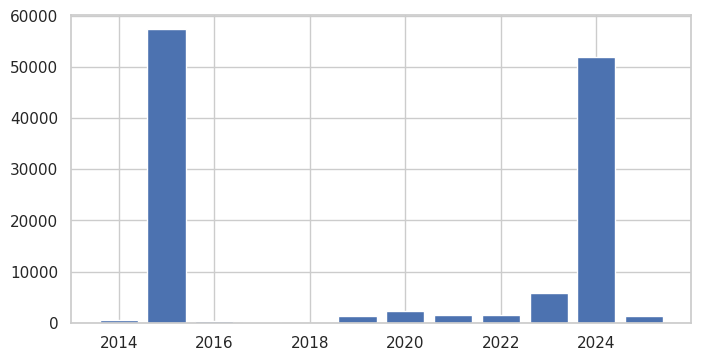

In [ ]:
casos_anos = casos.groupby(by='ano')['casos'].sum().reset_index()
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(casos_anos.ano,casos_anos.casos)
fig.show()

Por 100 mil habitantes
usando os dados da [BD](https://basedosdados.org/dataset/1e2b9a88-9dc7-4f0e-a3a5-e8d2a13869bf?raw_data_source=07c56061-07d4-4d56-b96f-35d218e7ae6e) e os dados do [tabnet](http://tabnet.datasus.gov.br/cgi/deftohtm.exe?ibge/cnv/popsvs2024br.def)

In [ ]:
select = f"""select ano, sum(populacao) as populacao
         from `basedosdados.br_ms_populacao.municipio` pop
         join `basedosdados.br_bd_diretorios_brasil.municipio` municipio
         on pop.id_municipio = municipio.id_municipio
         where municipio.nome = '{cidade}'
         and ano > 2013
         group by ano
         order by ano"""

In [ ]:
pop = bd.read_sql(select, billing_project_id='testes-proforest')

Downloading: 100%|██████████|


In [ ]:
#População Americana
pop.loc[8] = [2022,243401]
pop.loc[9] = [2023,245019]
pop.loc[10] = [2024,246655]


In [ ]:
#População Sorocaba
pop.loc[8] = [2022,736912]
pop.loc[9] = [2023,747045]
pop.loc[10] = [2024,757459]

In [ ]:
#População Curitiba
pop.loc[8] = [2022,1836535]
pop.loc[9] = [2023,1836238]
pop.loc[10] = [2024,1829225]

In [ ]:
pop

,ano,populacao
0,2014,1851472
1,2015,1868522
2,2016,1884840
3,2017,1900892
4,2018,1917185
5,2019,1933105
6,2020,1948626
7,2021,1963726
8,2022,1836535
9,2023,1836238


In [ ]:
casos_100k = casos_anos.merge(pop, on='ano')

In [ ]:
casos_100k['por_100k'] = casos_100k['casos']*1000000/casos_100k['populacao']

In [ ]:
casos_100k

,ano,casos,populacao,por_100k
0,2014,552,636681,866.996188
1,2015,57340,645700,88802.849621
2,2016,445,654407,680.004951
3,2017,71,662796,107.12195
4,2018,59,671186,87.904098
5,2019,1299,679378,1912.043075
6,2020,2225,687357,3237.03694
7,2021,1499,695328,2155.817111
8,2022,1484,736912,2013.808976
9,2023,5867,747045,7853.60989


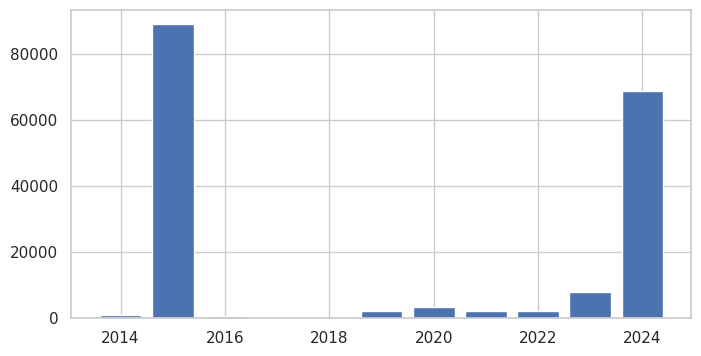

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(casos_100k.ano,casos_100k.por_100k)
fig.show()

## Para a BD Letter
### Comparando as três cidades

In [ ]:
cidades = ['Americana','Sorocaba','Curitiba']

In [ ]:
select = f"""select municipio.nome as cidade, data_notificacao as data, count(*) as casos
from `basedosdados.br_ms_sinan.microdados_dengue` dengue
join `basedosdados.br_bd_diretorios_brasil.municipio` municipio
on dengue.id_municipio_notificacao = municipio.id_municipio
WHERE classificacao_final IN ("10", "11", "12")
AND tipo_notificacao = "2"
AND municipio.nome in {cidades}
group by nome, id_municipio_notificacao, ano, data_notificacao
order by nome, id_municipio_notificacao, ano, data_notificacao
  """

In [ ]:
select = select.replace('[','(')
select = select.replace(']',')')

In [ ]:
df = bd.read_sql(select, billing_project_id='testes-proforest')

Downloading: 100%|██████████|


In [ ]:
df['semana'] = 0
df['ano'] = 1990

In [ ]:
for i, row in df.iterrows():
  df.at[i,'semana'] = Week.fromdate(row['data'],'ISO').week
  df.at[i,'ano']=Week.fromdate(row['data'],'ISO').year

In [ ]:
casos = df.groupby(by=['cidade','ano','semana'])['casos'].sum().reset_index()

In [ ]:
casos_ano = casos.groupby(by=['cidade','ano'])['casos'].sum().reset_index()

In [ ]:
select = f"""select municipio.nome as cidade, ano, sum(populacao) as populacao
         from `basedosdados.br_ms_populacao.municipio` pop
         join `basedosdados.br_bd_diretorios_brasil.municipio` municipio
         on pop.id_municipio = municipio.id_municipio
         where municipio.nome in {cidades}
         and ano > 2013
         group by nome, ano
         order by nome, ano"""

In [ ]:
select = select.replace('[','(')
select = select.replace(']',')')

In [ ]:
pop = bd.read_sql(select, billing_project_id='testes-proforest')

Downloading: 100%|██████████|


In [ ]:
pop

,cidade,ano,populacao
0,Americana,2014,226644
1,Americana,2015,229380
2,Americana,2016,232022
3,Americana,2017,234567
4,Americana,2018,237112
5,Americana,2019,239597
6,Americana,2020,242018
7,Americana,2021,244370
8,Curitiba,2014,1851472
9,Curitiba,2015,1868522


In [ ]:
#População Americana
pop.loc[24] = ['Americana',2022,243401]
pop.loc[25] = ['Americana',2023,245019]
pop.loc[26] = ['Americana',2024,246655]


In [ ]:
#População Sorocaba
pop.loc[27] = ['Sorocaba',2022,736912]
pop.loc[28] = ['Sorocaba',2023,747045]
pop.loc[29] = ['Sorocaba',2024,757459]

In [ ]:
#População Curitiba
pop.loc[30] = ['Curitiba',2022,1836535]
pop.loc[31] = ['Curitiba',2023,1836238]
pop.loc[32] = ['Curitiba',2024,1829225]

In [ ]:
casos_100k = casos.merge(pop, on=['cidade','ano'])

In [ ]:
casos_100k['por_100k'] = casos_100k['casos']/casos_100k['populacao']*100000

In [ ]:
casos_100k

,cidade,ano,semana,casos,populacao,por_100k
0,Americana,2014,1,6,226644,2.647324
1,Americana,2014,2,23,226644,10.148074
2,Americana,2014,3,32,226644,14.119059
3,Americana,2014,4,46,226644,20.296147
4,Americana,2014,5,67,226644,29.56178
...,...,...,...,...,...,...
1282,Sorocaba,2024,48,26,757459,3.432529
1283,Sorocaba,2024,49,20,757459,2.640407
1284,Sorocaba,2024,50,20,757459,2.640407
1285,Sorocaba,2024,51,28,757459,3.69657


### Gráficos

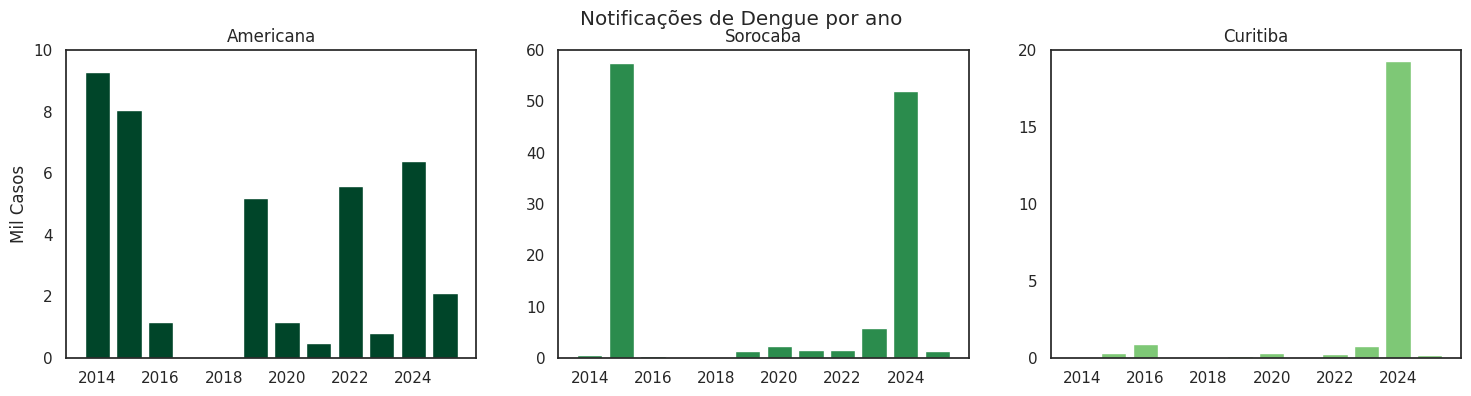

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
#casos absolutos
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

#Americana
subset = casos_ano[casos_ano.cidade=='Americana']
axs[0].bar(subset.ano,subset.casos/1000,color='#004529')
axs[0].set_ylabel('Mil Casos')
axs[0].set_ylim(0,10)
axs[0].set_title('Americana')

#Sorocaba
subset = casos_ano[casos_ano.cidade=='Sorocaba']
axs[1].bar(subset.ano,subset.casos/1000,color='#2B8C4D')
axs[1].set_ylim(0,60)
axs[1].set_title('Sorocaba')

#Curitiba
subset = casos_ano[casos_ano.cidade=='Curitiba']
axs[2].bar(subset.ano,subset.casos/1000,color='#7Ec876')
axs[2].set_ylim(0,20)
axs[2].set_yticks(np.arange(0,21,5))
axs[2].set_title('Curitiba')

fig.suptitle('Notificações de Dengue por ano')
fig.show()
fig.savefig('notificacoes.svg')

In [ ]:
casos_ano

,cidade,ano,casos
0,Americana,2014,9287
1,Americana,2015,8049
2,Americana,2016,1172
3,Americana,2017,26
4,Americana,2018,19
5,Americana,2019,5175
6,Americana,2020,1153
7,Americana,2021,481
8,Americana,2022,5587
9,Americana,2023,803


In [ ]:
casos_100k = casos_100k.groupby(by=['cidade','ano'])['por_100k'].sum().reset_index()

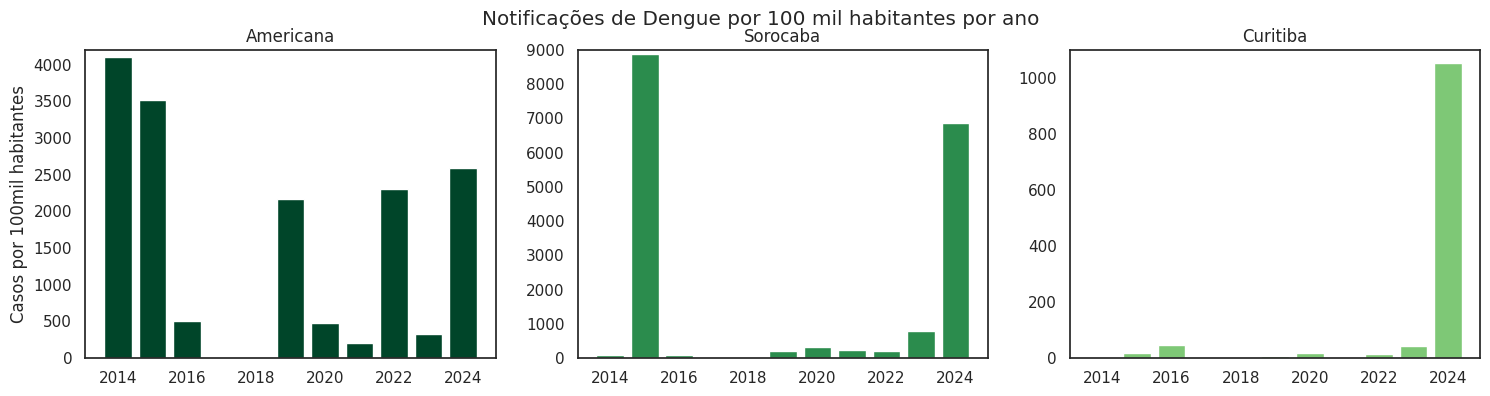

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
#casos absolutos
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

#Americana
subset = casos_100k[casos_100k.cidade=='Americana']
axs[0].bar(subset.ano,subset.por_100k,color='#004529')
axs[0].set_ylabel('Casos por 100mil habitantes')
axs[0].set_ylim(0,4200)
axs[0].set_title('Americana')

#Sorocaba
subset = casos_100k[casos_100k.cidade=='Sorocaba']
axs[1].bar(subset.ano,subset.por_100k,color='#2B8C4D')
axs[1].set_ylim(0,9000)
axs[1].set_title('Sorocaba')

#Curitiba
subset = casos_100k[casos_100k.cidade=='Curitiba']
axs[2].bar(subset.ano,subset.por_100k,color='#7Ec876')
axs[2].set_ylim(0,1100)
axs[2].set_title('Curitiba')

fig.suptitle('Notificações de Dengue por 100 mil habitantes por ano')
fig.show()
fig.savefig('notificacoes_100k.svg')

In [ ]:
subset = casos_100k[casos_100k.cidade=='Sorocaba']


In [ ]:
subset

,cidade,ano,por_100k
22,Sorocaba,2014,86.699619
23,Sorocaba,2015,8880.284962
24,Sorocaba,2016,68.000495
25,Sorocaba,2017,10.712195
26,Sorocaba,2018,8.79041
27,Sorocaba,2019,191.204307
28,Sorocaba,2020,323.703694
29,Sorocaba,2021,215.581711
30,Sorocaba,2022,201.380898
31,Sorocaba,2023,785.360989
